# Lab3_MIA_BME_23_24_Group11

Medical Image Analysis: Lab 3 Registration

Group 11:
- Enrique Almazán Sánchez
- Guillermo Ots Rodríguez
- Javier Villoldo Fernández

# Objectives

The goal of this Laboratory is to become familiar with registration pipelines that have been covered in class and to gain a deeper understanding of the fundamental underlying procedures and their applicability to medical image tasks. In particular, **geometric transformations**, **interpolation** and **rigid registration methods** will be implemented.

Additionally we will work on the implementation of our own transformation, interpolation and mutual information functions. We think this is a good approach as we will not only learn about the processes used but also gain knowledge from the investigation activity required for their application.

We will apply these algorithms to a real CT slice evaluating the results and assesing how well the algorithm achieves its intended goal, searching for the geometric transformation that puts two images into spatial concordance.

## Dependencies (required libraries)
The required denpendencies or libraries for this project are the following ones:

- **NumPy (Numerical Python)**: fundamental library for numerical computing in Python. It provides support for large, multi-dimensional arrays and matrices, along with a wide range of mathematical functions to operate on these arrays efficiently.


- **matplotlib.pyplot (Matplotlib's Pyplot Module)**: powerful library for creating static, animated, or interactive visualizations in Python. The pyplot module provides a simple and MATLAB-like interface for creating plots and charts.


- **OpenCV (cv2)**: OpenCV (Open Source Computer Vision Library) is a library dedicated to computer vision and image processing tasks. It offers a wide range of functions for image analysis, including image filtering, object detection and feature extractiona.


- **scikit-image (skimage)**: an image processing library built on top of SciPy and NumPy. It provides tools and algorithms for a wide range of image processing tasks, making it useful for tasks such as feature extraction and image enhancement.


- **SciPy**: a scientific library that builds on NumPy and provides additional functionality for scientific and technical computing. It includes tools for optimization, signal processing, statistical analysis, and more.

- **Nibabel**: library used for reading and writing neuroimaging file formats, such as NIfTI and ANALYZE. It provides a convenient interface for working with these data formats in the field of neuroimaging research and analysis.


### Imports

In [1]:
import random

import numpy as np
from numpy import meshgrid

import matplotlib.pyplot as plt

import cv2 as cv

import nibabel as nib

from skimage import io
from skimage import exposure
from skimage.exposure import histogram

from scipy import ndimage
from scipy.ndimage import affine_transform
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import entropy
from scipy.optimize import minimize

## Loading Image and selecting a slice

First we import the entire volumetric image and take the slice that will be used throughout the lab practice.

In [2]:
ct_vol = nib.load('ct.nii')
ct_array = ct_vol.get_fdata()
print(ct_array.shape)

# Accessing a specific slice along the z-axis
ct_array = ct_array.transpose(1, 0, 2)
ct_slice = ct_array[:, :, 105]
print(ct_slice.shape)

# Save the slice as a jpeg image to then process and make registration with
save_path_jpeg = 'ct_slice.jpeg'
plt.imsave(save_path_jpeg, ct_slice, cmap='gray', format='jpeg')

(271, 271, 221)
(271, 271)


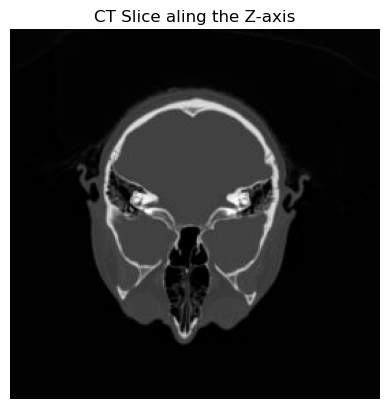

In [3]:
ct = cv.imread('ct_slice.jpeg', cv.IMREAD_GRAYSCALE)
# Normalize the image so that algorithms are applied in the same way
ct = ct/np.max(ct)

height, width = ct.shape

# Display results
# Computing the figure
plt.imshow(ct, cmap=plt.cm.gray)
plt.title('CT Slice aling the Z-axis'), plt.axis('off')
plt.show()

## Bilinear Interpolation Function

A function that interpolates the transformed image. Interpolation will estimate the values of the points from the transformed image grid such that they fall back into the grid of the original image.

Bilinear interpolation is performed using linear interpolation first in one direction, and then again in the other direction. It uses values of only the 4 nearest pixels, located in diagonal directions from a given pixel, in order to find the appropriate intensity values of that pixel

In [4]:
def bilinear_interpolate(image, points):
    """
    Interpolate points in a transformed image from the original image points using regular grid interpolation.

    Parameters:
    - image: The 2D array representing the image.
    - points: An array of 2D coordinates where interpolation should be performed.

    Returns:
    - Interpolated values corresponding to the input points.
    """

    # Create a 2D interpolator for the input image using regular grid interpolation
    interpolator = RegularGridInterpolator(
        (np.arange(image.shape[0]), np.arange(image.shape[1])),
        image,
        method='linear',  # Bilinear interpolation
        bounds_error=False,  # Allow interpolation outside the bounds, using fill_value
        fill_value=0  # Value to be used for points outside the image bounds
    )

    # Perform interpolation on the given points
    interpolated_values = interpolator(points)

    # Return the interpolated values
    return interpolated_values

The **manual interpolation** function estimates values at new grid points by computing a weighted sum of pixel values from the four nearest neighbors. This is based on their distances from the input coordinates, hence adjusting the displaced coordinates.

The fractional parts, dx and dy, indicate the distance of the input coordinates from their floor values, influencing the interpolation weights.
 - floor value: The largest integer less than or equal to a given number.
 - ceil value: The smallest integer greater than or equal to a given number.

To prevent index out-of-bounds errors, coordinates are clipped to the image boundaries. This ensures that the calculated coordinates fall within the valid range of image indices. The result is a bilinear interpolation, providing smoother transitions between pixel values for transformed image points.

In [5]:
def bilinear_interpolate_manual(image, points):
    """
    Interpolate points of transformed image from original image points.

    Parameters:
    - image: The 2D array representing the image.
    - points: An array of 2D coordinates where interpolation should be performed.

    Returns:
    - Interpolated Image
    """
        
    height, width = image.shape
    x, y = points[:, 0], points[:, 1]

    # Floor and ceil coordinates
    x_floor, y_floor = np.floor(x).astype(int), np.floor(y).astype(int)
    x_ceil, y_ceil = np.ceil(x).astype(int), np.ceil(y).astype(int)

    # Clip coordinates to image boundaries
    x_floor = np.clip(x_floor, 0, width - 1)
    y_floor = np.clip(y_floor, 0, height - 1)
    x_ceil = np.clip(x_ceil, 0, width - 1)
    y_ceil = np.clip(y_ceil, 0, height - 1)

    # Calculate fractional parts
    dx, dy = x - x_floor, y - y_floor

    # Bilinear interpolation
    interpolated_values = (
        image[y_floor, x_floor] * (1 - dx) * (1 - dy) +
        image[y_floor, x_ceil] * dx * (1 - dy) +
        image[y_ceil, x_floor] * (1 - dx) * dy +
        image[y_ceil, x_ceil] * dx * dy
    )

    return interpolated_values

## Transformation Function

This is a function that applies a rigid transform (translation + rotation with 6 degrees of freedom) to an image with the parameters passed to it as input. The transformations are achieved by multiplying by the matrix corresponding to each of them.

In [6]:
def transformation(image, angle, translation):
    """
    Apply a transformation (rotation and translation) to the input image.

    Parameters:
    - image: The 2D array representing the image.
    - angle: The angle of rotation in radians.
    - translation: A tuple representing translation in the form (tx, ty).

    Returns:
    - Transformed image after rotation and translation.
    """
    
    # Create an affine transformation matrix for rotation and translation
    transformation_matrix = np.array([[np.cos(angle), -np.sin(angle), translation[0]],
                                      [np.sin(angle), np.cos(angle), translation[1]],
                                      [0, 0, 1]])

    # Apply the affine transformation to the image
    rotated_translated_img = affine_transform(image, matrix=transformation_matrix)

    # Return the transformed image
    return rotated_translated_img

A previous implementation to see how our transformation function works is shown below.

(Text(0.5, 1.0, 'Transformed CT with Matrices'), (-0.5, 270.5, 270.5, -0.5))

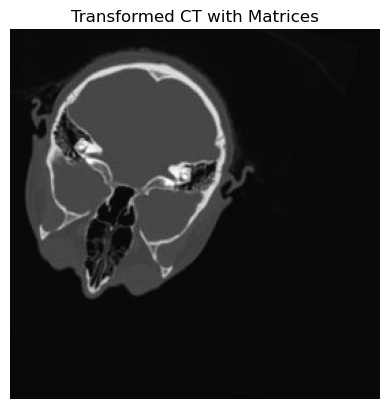

In [7]:
transformed_image = transformation(ct, angle=np.radians(15), translation=[55.1, 20.1])
plt.imshow(transformed_image, cmap=plt.cm.gray)
plt.title('Transformed CT with Matrices'), plt.axis('off')

## Mutual Information Function


This function will be implemented to calculate the mutual information between the two images. 
Mutual Information is an s intensity-based measure that does not rely on specific image features and is used as a similarity metric to quantify the amount of information shared between two images. The optimization process aims to find the appropiate transformation parameters that minimize this measure, which would indicate a good alignment between the images.

                                                    MI(I,J)=H(I)+H(J)−H(I,J)

For two images \(I\) and \(J\) their intensity values are treated as random variables. The joint probability density function 
\(P(I,J)\) represents the probability of observing a specific pair of intensity values \(I,J\) in the images. The marginal probability density functions \(P(I)\) and \(P(J)\) represent the probabilities of observing specific intensity values in each image independently. We find these joint and marginal probabilities from the joint and marginal histograms respectevely.

The entropy, which is a measure of the uncertainty of a random variable, is calculated, for the random variables \(I\), \(J\) and \(I,J\). Then with teh equation provided above the mutual information between images is calculated, measuring the reduction in uncertainty about one image when the other image is known.

In [8]:
def mutual_information(image1, image2, bins=271):
    """
    Calculate mutual information between two 2D images.

    Parameters:
    - image1: 2D numpy array representing the first image
    - image2: 2D numpy array representing the second image
    - bins: Number of bins for histogram calculation

    Returns:
    - Mutual information value
    """
    # Ensure the images have the same shape
    assert image1.shape == image2.shape, "Input images must have the same shape"

    # Flatten the images
    flat_image1 = image1.flatten()
    flat_image2 = image2.flatten()

    # Calculate joint histogram
    joint_histogram, _, _ = np.histogram2d(flat_image1, flat_image2, bins=bins)
    
    # Normalize the joint histogram
    joint_prob = joint_histogram / np.sum(joint_histogram)
    joint_prob = np.nonzero(joint_prob) # dont take values that make the division NaN
    
    # Calculate marginal histograms
    hist_image1, _ = np.histogram(flat_image1, bins=bins)
    hist_image2, _ = np.histogram(flat_image2, bins=bins)

    # Normalize the marginal histograms
    prob_image1 = hist_image1 / np.sum(hist_image1)
    prob_image2 = hist_image2 / np.sum(hist_image2)   

    # Calculate entropies
    entropy_image1 = entropy(prob_image1)
    entropy_image2 = entropy(prob_image2)
    joint_entropy = entropy(joint_prob)
    
    # Calculate mutual information
    mutual_info = entropy_image1 + entropy_image2 - joint_entropy
    return sum(mutual_info)

## Optimization of Mutual Information for Rigid Registration

The optimization of MI function consists of an iterative process used to find the rotation angle and translation vector that returns the transformed image to the same state of the original image, by minimization of the mutual information metric. Actually, what is being minimized is the negative of the mutual information, since the MI quantifies the amount of information shared between two images, the aim, then, is to increase the MI metric, which is equivalent to minimizing the negative of the MI.

In each iteration of the optimization process, a transformation is applied to the initially transformed image and the negative of the mutual information is calculated between the newly transformed image and the original image. After that, these steps are repeated until a stopping criterion, defined a priori, is reached.


In [9]:
def min_mutual_info(params, image1, image2):
    """
    Function to minimize - returns the negative mutual information.

    Parameters:
    - params: Parameters to optimize
    - image1: 2D numpy array representing the first image
    - image2: 2D numpy array representing the second image

    Returns:
    - Negative mutual information value
    """
    
    # Unpack the parameters
    angle, translation_x, translation_y = params

    # Rotate and translate the image with the rigid function transformation
    rotated_translated_img = transformation(image2, angle, [translation_x, translation_y])
    
    # Calculate mutual information (negative because we are minimizing)
    return -mutual_information(image1, rotated_translated_img)

## Additional Helpful Functions

Now we calculate the pixel grid of the original image, since it is one of the parameters required for the interpolating function, aside from the transformed image. The plot of a pixel grid coded in a different function below for visualization purposes.

In [10]:
def create_grid(image_shape, spacing):
    """
    Create a regular grid of points covering the given image shape with specified spacing.

    Parameters:
    - image_shape: A tuple representing the shape of the image (rows, cols).
    - spacing: The spacing between grid points.

    Returns:
    - 2D array representing a regular grid of points.
    """
    
    # Extract the number of rows and columns from the image shape
    rows, cols = image_shape
    
    # Create a mesh grid of x and y coordinates
    y, x = np.mgrid[0:rows, 0:cols]
    
    # Flatten the x and y coordinates
    x_flat = x.flatten()
    y_flat = y.flatten()
    
    # Create a 2D array representing the regular grid of points
    grid = np.column_stack((x_flat, y_flat, np.ones_like(x_flat)))
    
    return grid

In [11]:
def plot_grid_overlay(original_grid, transformed_grid, transformed_img):
    """
    Plot an overlay of original and transformed grids along with the transformed image.

    Parameters:
    - original_grid: 2D array representing the original grid points.
    - transformed_grid: 2D array representing the transformed grid points.
    - transformed_img: The transformed image to be displayed.

    Returns:
    - None
    """
    
    # Set up the figure
    plt.figure(figsize=(10, 5))

    # Plot original grid with connecting lines along the x-axis
    for i in range(original_grid.shape[0]):
        plt.plot([original_grid[i, 0], original_grid[i, 0]], [0, original_grid[i, 1]], 'b-', linewidth=0.1)

    # Plot original grid with connecting lines along the y-axis
    for i in range(original_grid.shape[0]):
        plt.plot([0, original_grid[i, 0]], [original_grid[i, 1], original_grid[i, 1]], 'b-', linewidth=0.1)
        
    # Scatter plot for the original pixel grid
    plt.scatter(original_grid[:, 0], original_grid[:, 1], c='orange', s=5, marker='.', zorder=2, label="Original Pixel Grid")

    # Scatter plot for the transformed pixel grid
    plt.scatter(transformed_grid[:, 0], transformed_grid[:, 1], c='red', s=5, marker='.', label="Displaced Pixel Grid")
    
    # Display the legend in the upper right corner
    plt.legend(loc='upper right')
    
    # Set limits for the x and y axes
    plt.xlim(30, 50)
    plt.ylim(30, 50)
    
    # Set the title for the plot
    plt.title('Transformed Grid Overlayed with Original grid and Transformed Image')
    
    # Display the transformed image using a grayscale colormap
    plt.imshow(transformed_img, cmap=plt.cm.gray)

    # Show the plot
    plt.show()

## Implementation of the functions created

First of all, we perform the transformation of the original grid with the same rotation and translation as the original image, so that it can be visually appreciated how the transformation causes a shift in the pixel grid that will later need to be corrected for an accurate registration.

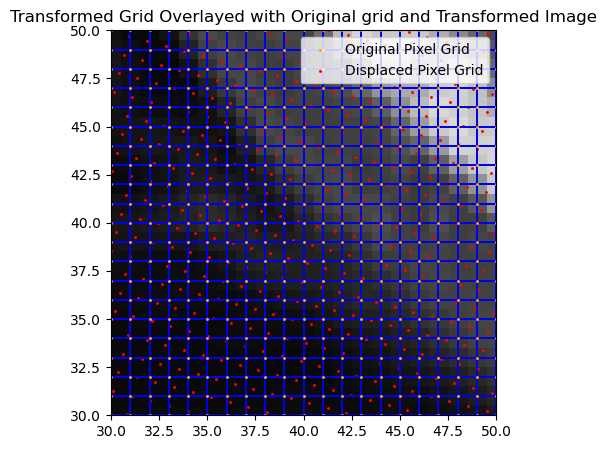

(73441, 3)


In [12]:
# Define rotation angle and translation
rotation_angle = np.radians(15)
translation_vector = [55.1, 20.1]

# Apply rotation and translation transformation to the image
apply_img = transformation(ct, rotation_angle, translation_vector)

# Create grid for the original
original_grid = create_grid(ct.shape, spacing=10)
transformed_grid = create_grid(transformed_image.shape, spacing=10)

# Apply the same rotation and translation to the grids
original_grid_transformed = np.dot(original_grid, [[np.cos(rotation_angle), -np.sin(rotation_angle), translation_vector[0]],
                                                  [np.sin(rotation_angle), np.cos(rotation_angle), translation_vector[1]],
                                                  [0, 0, 1]])

# Plot the grids overlay
plot_grid_overlay(original_grid, original_grid_transformed, transformed_image)

print(original_grid_transformed[:,:].shape)

The size of the interpolated_values array should be equal to the product of the dimensions of the original image.

In [13]:
# Bilinear interpolation on the transformed image using the original grid points
interpolated_values = bilinear_interpolate_manual(transformed_image, original_grid)
print('Size of interpolated values', interpolated_values.shape)

# Reshape the interpolated values to the shape of the original image
interpolated_ct = interpolated_values.reshape(ct.shape)
print('Size of the interpolated image:', interpolated_ct.shape)

Size of interpolated values (73441,)
Size of the interpolated image: (271, 271)


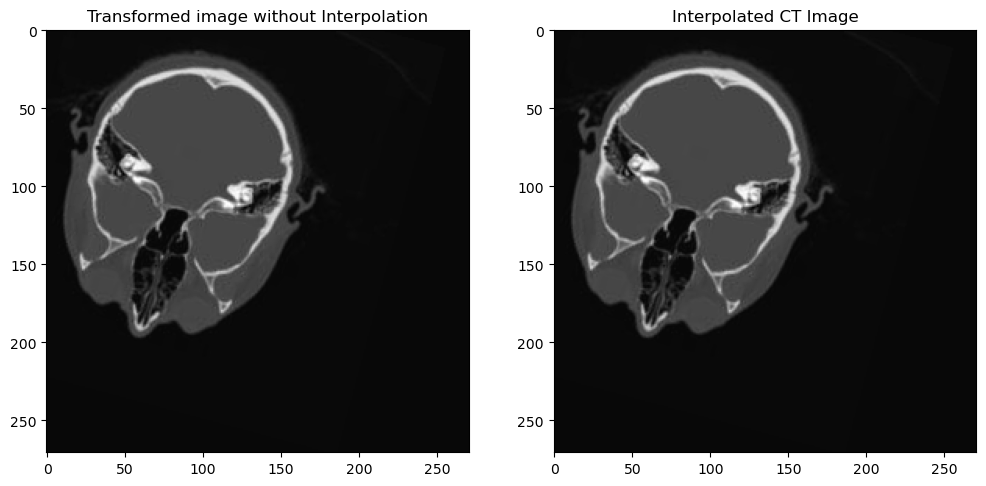

In [14]:
fig = plt.figure(figsize=(12, 12))
# Plot the bilinear interpolated values on the original image
plt.subplot(1,2,1)
plt.imshow(transformed_image, cmap=plt.cm.gray)
plt.title('Transformed image without Interpolation')
# Second subplot:
plt.subplot(1,2,2)
plt.imshow(interpolated_ct, cmap=plt.cm.gray)
plt.title('Interpolated CT Image')

plt.show()

In [15]:
# Calculating mmutual information from joint and marginal entropies
mutual_info = mutual_information(ct, transformed_image)
print("Mutual Information:", mutual_info)

Mutual Information: 27336.940431624425


The optimization algorithm will then minimize this cost function to find the optimal transformation parameters that reverse the initial deformation applied to our image.

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -28713.69094999153
       x: [-1.252e+01 -3.524e+01 -1.394e+01]
     nit: 4
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00  1.000e+00]]
    nfev: 439
Optimized Rotation Angle: -12.51546009870478
Optimized Translation Vector: [-35.24409977 -13.93939894]


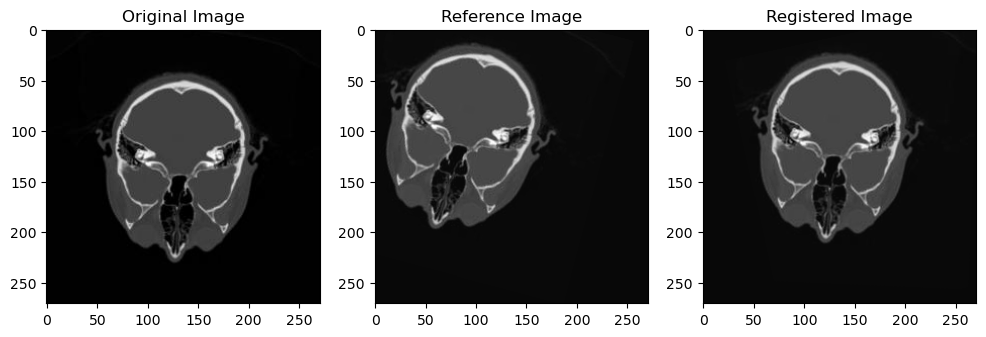

In [17]:
# Define initial guess for parameters (rotation angle and translation)
initial_params = [-1, -1, -1]  # [rotation_angle, translation_x, translation_y] Start with values different than zero to guide the algorithm in the correct direction in its first iterations
bounds = [(-20, 0), (-40, 0), (-40, 0)]

# Minimize the cost function using scipy.optimize.minimize
result = minimize(min_mutual_info, initial_params, args=(interpolated_ct, ct), method='Powell', bounds=bounds, tol=1e-7)

# Extract the optimized parameters
print(result) # To check that optimization was terminated succesfully and not because of a NaN value error
optimized_rotation_angle = result.x[0]
optimized_translation_vector = result.x[1:]

# Apply the optimized transformation to the original image
registered_image = transformation(interpolated_ct, np.radians(optimized_rotation_angle), optimized_translation_vector)

# Print the optimized parameters
print("Optimized Rotation Angle:", optimized_rotation_angle)
print("Optimized Translation Vector:", optimized_translation_vector)

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(ct, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(interpolated_ct, cmap='gray')
plt.title('Reference Image')

plt.subplot(1, 3, 3)
plt.imshow(registered_image, cmap='gray')
plt.title('Registered Image')

plt.show()